In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, UpSampling3D, Input, ZeroPadding3D, Lambda, Reshape
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf

import numpy as np

import sys
import argparse
import os
import glob 

import dcor

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def PIL2array(img):
    return numpy.array(img.getdata(),
                numpy.uint8).reshape(img.size[1], img.size[0], 3)
def array2PIL(arr, size):
    mode = 'RGBA'
    arr = arr.reshape(arr.shape[0]*arr.shape[1], arr.shape[2])
    if len(arr[0]) == 3:
       arr = numpy.c_[arr, 255*numpy.ones((len(arr),1), numpy.uint8)]
    return Image.frombuffer(mode, size, arr.tostring(), 'raw', mode, 0, 1)

def return_x(y,color,direction):

    if color == "blue" and direction == "up":
       m = (4.0 + 6.0/11.0)
       c = 0.5
    elif color == "blue" and direction == "down":
       m = -3.226
       c = 2.097
    elif color == "green" and direction == "up":
       m = 4.0
       c = -0.5
    elif color == "green" and direction == "down":
       m = -3.704
       c = 3.370
    elif color == "red" and direction == "up":
       m = 3.223
       c = -1.129
    elif color == "red" and direction == "down":
       m = -4.545
       c = 5.041
    else:
       m = 1
       c = 0

    return (y-c)/m 

# x >= y
def big_equal(x,y):
    return x > y or np.allclose(x,y)

# x <= y
def less_equal(x,y):
    return x < y or np.allclose(x,y)

def convert_jet_to_grey(img_array,n):
    new_image = np.zeros((img_array.shape[0],img_array.shape[1]))
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            pixel_blue = img_array[i,j,2]
            pixel_green = img_array[i,j,1]
            pixel_red = img_array[i,j,0]
            if (pixel_blue < 1) and big_equal(pixel_blue,0.5) and less_equal(pixel_green,0.5) :
               #print "a1"
               #print "i,j = ",i,",",j
               new_image[i,j] = return_x(pixel_blue,"blue","up")**n
            elif np.allclose(pixel_blue,1.0) and big_equal(pixel_green,0):
                 #print "b1"
                 #print "i,j = ",i,",",j
                 new_image[i,j] = return_x(pixel_green,"green","up")**n
            elif (pixel_blue < 1) and big_equal(pixel_blue,0.4) and big_equal(pixel_green,0.5):
                 #print "c1"
                 #print "i,j = ",i,",",j
                 new_image[i,j] = return_x(pixel_green,"blue","down")**n
            elif (pixel_red < 1) and big_equal(pixel_red,0.4) and big_equal(pixel_green,0.5):
                 #print "c2"
                 #print "i,j = ",i,",",j
                 new_image[i,j] = return_x(pixel_green,"red","up")**n
            elif np.allclose(pixel_red,1.0) and big_equal(pixel_green,0):
                 #print "b2"
                 #print "i,j = ",i,",",j
                 new_image[i,j] = return_x(pixel_green,"green","down")**n
            elif (pixel_red < 1) and big_equal(pixel_red,0.5) and less_equal(pixel_green,0.5):
            #print "a2"
            #print "i,j = ",i,",",j
                 new_image[i,j] = return_x(pixel_blue,"red","down")**n

    return new_image

In [3]:
# In[2]:
def augment_by_transformation(data,age,sex,n):
    augment_scale = 1

    if n <= data.shape[0]:
        return data
    else:
        raw_n = data.shape[0]
        m = n - raw_n
        for i in range(0,m):
            new_data = np.zeros((1,data.shape[1],data.shape[2],data.shape[3],1))
            idx = np.random.randint(0,raw_n)
            new_age = age[idx]
            new_sex = sex[idx]
            new_data[0] = data[idx].copy()
            new_data[0,:,:,:,0] = sp.ndimage.interpolation.rotate(new_data[0,:,:,:,0],np.random.uniform(-1,1),axes=(1,0),reshape=False)
            new_data[0,:,:,:,0] = sp.ndimage.interpolation.rotate(new_data[0,:,:,:,0],np.random.uniform(-1,1),axes=(0,1),reshape=False)
            new_data[0,:,:,:,0] = sp.ndimage.shift(new_data[0,:,:,:,0],np.random.uniform(-1,1))
            data = np.concatenate((data, new_data), axis=0)
            age = np.append(age, new_age)
            sex = np.append(sex, new_sex)
        return data,age,sex

def inv_correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-7
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-7
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return K.square(r)

In [4]:
class GAN():
    
    def __init__(self):

        optimizer = Adam(0.0002)
        optimizer_distiller = Adam(0.0002)
        optimizer_regressor = Adam(0.0002)

        # Build and compile the cf predictorinv_inv
        self.regressor = self.build_regressor()
        self.regressor.compile(loss='mse', optimizer=optimizer_regressor)

        # Build the feature encoder
        input_feature = Input(shape=(128,1,1), name='input_image')
        feature_dense = Flatten()(input_feature)
        feature_dense = Dense(64,activation='tanh')(feature_dense)
        
        self.encoder = Model(input_feature, feature_dense)
        
        # For the distillation model we will only train the encoder

        self.regressor.trainable = False

        cf = self.regressor(feature_dense)
        self.distiller = Model(input_feature, cf)
        self.distiller.compile(loss=correlation_coefficient_loss, optimizer=optimizer_distiller)

        # Build and Compile the classifer   
        feature_clf = Dense(16, activation='tanh')(feature_dense)
        label = Dense(1, activation='sigmoid', name='r_mean')(feature_clf)
        
        self.classifier = Model(input_feature, label)
        self.classifier.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

        
    def build_regressor(self):
        inputs_x = Input(shape=(64,))
        feature = Dense(16, activation='tanh')(inputs_x)
        cf = Dense(1)(feature)

        return Model(inputs_x, cf)

    def train(self, epochs, training, testing, testing_raw, batch_size=64, fold=0):
        [train_data_aug, train_dx_aug, train_age_aug, train_sex_aug] = training
        [test_data_aug,  test_dx_aug,  test_age_aug,  test_sex_aug]  = testing
        [test_data    ,  test_dx    ,  test_age,      test_sex   ]   = testing_raw
        
        dc = np.zeros((int(epochs/100),))
        for epoch in range(epochs):

            # ---------------------
            #  Train Disstiller
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, int(train_data_aug.shape[0]/2), int(batch_size/2))
            idx = np.concatenate((idx,idx+int(train_data_aug.shape[0]/2)))
 
            training_feature_batch = train_data_aug[idx]
            dx_batch = train_dx_aug[idx]
            age_batch = train_age_aug[idx]

            training_feature_ctrl_batch = training_feature_batch[dx_batch == 0]
            age_ctrl_batch = age_batch[dx_batch == 0]
            
            # Train the discriminator
            encoded_feature_ctrl_batch = self.encoder.predict(training_feature_ctrl_batch)
            #r_loss = self.regressor.train_on_batch(encoded_feature_ctrl_batch, age_ctrl_batch)

            # ---------------------
            #  Train Encoder & Classifier
            # ---------------------
            c_loss = self.classifier.train_on_batch(training_feature_batch, dx_batch)            
            #g_loss = self.distiller.train_on_batch(training_feature_ctrl_batch, age_ctrl_batch)


            c_loss_test = self.classifier.evaluate(test_data_aug, test_dx_aug, verbose = 0, batch_size = batch_size)    

            # Plot the progress
            if epoch % 100 == 0:
                # feature dist corr
                features_dense = self.encoder.predict(test_data_aug,  batch_size = batch_size)
                #[dc, pval] = distcorr(features_dense[test_dx_aug==0], test_age_aug[test_dx_aug==0])
                dc[int(epoch/100)] = dcor.u_distance_correlation_sqr(features_dense[test_dx_aug==0], test_age_aug[test_dx_aug==0])
                
                #print ("%d [Cov: %f, DC: %f, p: %f, Acc: %f,  Test Acc: %f]" % (epoch, g_loss, dc, pval, c_loss[1], c_loss_test[1]))
                print ("%d [DC: %f, Acc: %f,  Test Acc: %f]" % (epoch, dc[int(epoch/100)], c_loss[1], c_loss_test[1]))
                
                sys.stdout.flush()

        return dc
    
    def train_cf_free(self, epochs, training, testing, testing_raw, batch_size=64, fold=0):
        [train_data_aug, train_dx_aug, train_age_aug, train_sex_aug] = training
        [test_data_aug,  test_dx_aug,  test_age_aug,  test_sex_aug]  = testing
        [test_data    ,  test_dx    ,  test_age,      test_sex   ]   = testing_raw
            
        dc_cf = np.zeros((int(epochs/100),))
        for epoch in range(epochs):

            # ---------------------
            #  Train Disstiller
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, int(train_data_aug.shape[0]/2), int(batch_size/2))
            idx = np.concatenate((idx,idx+int(train_data_aug.shape[0]/2)))
 
            training_feature_batch = train_data_aug[idx]
            dx_batch = train_dx_aug[idx]
            age_batch = train_age_aug[idx]

            training_feature_ctrl_batch = training_feature_batch[dx_batch == 0]
            age_ctrl_batch = age_batch[dx_batch == 0]
            
            # Train the discriminator
            encoded_feature_ctrl_batch = self.encoder.predict(training_feature_ctrl_batch)
            r_loss = self.regressor.train_on_batch(encoded_feature_ctrl_batch, age_ctrl_batch)

            # ---------------------
            #  Train Encoder & Classifier
            # ---------------------
            c_loss = self.classifier.train_on_batch(training_feature_batch, dx_batch)            
            g_loss = self.distiller.train_on_batch(training_feature_ctrl_batch, age_ctrl_batch)


            c_loss_test = self.classifier.evaluate(test_data_aug, test_dx_aug, verbose = 0, batch_size = batch_size)    

            # Plot the progress
            if epoch % 100 == 0:
                # feature dist corr
                features_dense = self.encoder.predict(test_data_aug,  batch_size = batch_size)
                #[dc, pval] = distcorr(features_dense[test_dx_aug==0], test_age_aug[test_dx_aug==0])
                dc_cf[int(epoch/100)] = dcor.u_distance_correlation_sqr(features_dense[test_dx_aug==0], test_age_aug[test_dx_aug==0])
                
                #print ("%d [Cov: %f, DC: %f, p: %f, Acc: %f,  Test Acc: %f]" % (epoch, g_loss, dc, pval, c_loss[1], c_loss_test[1]))
                print ("%d [DC: %f, Acc: %f,  Test Acc: %f]" % (epoch, dc_cf[int(epoch/100)], c_loss[1], c_loss_test[1]))
                
                sys.stdout.flush()
        return dc_cf
    
    def visualization(self,training):
        [train_data_aug, train_dx_aug, train_age_aug, train_sex_aug] = training
        
        # Utility to search for layer index by name. 
        # Alternatively we can specify this as -1 since it corresponds to the last layer.
        layer_idx = utils.find_layer_idx(self.classifier, 'r_mean')

        # Swap softmax with linear
        self.classifier.layers[layer_idx].activation = activations.linear
        self.classifier = utils.apply_modifications(self.classifier)

        saliency = np.zeros((128,1))
        for i in range(train_data_aug.shape[0]):
            grads = visualize_saliency(self.classifier, layer_idx, filter_indices=0, seed_input=train_data_aug[i])
            saliency = saliency + convert_jet_to_grey(grads/255.0,1)
        saliency = saliency / train_data_aug.shape[0]
        return saliency, grads

In [5]:
np.random.seed(0)

N = 256 # number of subjects in a group
M = 64 # batch of features

age_offset = 1
feature_offset = 1
noise = 1

## age difference between 2 groups
age1 = np.random.normal(0,1,size=N)
age2 = np.random.normal(age_offset,1,size=N)

## simulate features
x1 = np.zeros((N,M*2))
x2 = np.zeros((N,M*2))

## cf_free features
x1[:,0:M] = np.random.normal(0,  noise, size=(N,M))
x2[:,0:M] = np.random.normal(feature_offset,  noise, size=(N,M))

## confounded features
for i in range(M):
    slope = np.random.normal(0,1)
    x1[:,i+M] = age1 * slope + np.random.normal(0,noise,size=(N,))
    x2[:,i+M] = age2 * slope + np.random.normal(0,noise,size=(N,))

## combinging the two groups
x = np.concatenate([x1,x2])
x = x.reshape(N*2,128,1,1)
age = np.concatenate([age1,age2])
dx = np.zeros((N*2,))
dx[N:] = 1
sex = np.zeros((N*2,))

import matplotlib
import matplotlib.pyplot as plt

#plt.imshow(x)
#plt.show()

In [6]:
gan = GAN()
dc = gan.train(epochs=10000, 
               training=[x, dx, age, sex], 
               testing=[x, dx, age, sex], 
               testing_raw=[x, dx, age, sex], batch_size=128, fold=0)

gan_cf = GAN()
dc_cf = gan_cf.train_cf_free(epochs=10000, 
                          training=[x, dx, age, sex], 
                          testing=[x, dx, age, sex], 
                          testing_raw=[x, dx, age, sex], batch_size=128, fold=0)

0 [DC: 0.837837, Acc: 0.390625,  Test Acc: 0.449219]
100 [DC: 0.814194, Acc: 0.875000,  Test Acc: 0.830078]
200 [DC: 0.791039, Acc: 0.960938,  Test Acc: 0.927734]
300 [DC: 0.776121, Acc: 0.968750,  Test Acc: 0.968750]
400 [DC: 0.771136, Acc: 0.992188,  Test Acc: 0.994141]
500 [DC: 0.765375, Acc: 1.000000,  Test Acc: 1.000000]
600 [DC: 0.761798, Acc: 1.000000,  Test Acc: 1.000000]
700 [DC: 0.760854, Acc: 1.000000,  Test Acc: 1.000000]
800 [DC: 0.761117, Acc: 1.000000,  Test Acc: 1.000000]
900 [DC: 0.759915, Acc: 1.000000,  Test Acc: 1.000000]
1000 [DC: 0.758297, Acc: 1.000000,  Test Acc: 1.000000]
1100 [DC: 0.757865, Acc: 1.000000,  Test Acc: 1.000000]
1200 [DC: 0.757239, Acc: 1.000000,  Test Acc: 1.000000]
1300 [DC: 0.756240, Acc: 1.000000,  Test Acc: 1.000000]
1400 [DC: 0.755498, Acc: 1.000000,  Test Acc: 1.000000]
1500 [DC: 0.754620, Acc: 1.000000,  Test Acc: 1.000000]
1600 [DC: 0.753803, Acc: 1.000000,  Test Acc: 1.000000]
1700 [DC: 0.753337, Acc: 1.000000,  Test Acc: 1.000000]
1800

/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [DC: 0.793241, Acc: 0.273438,  Test Acc: 0.328125]
100 [DC: 0.747245, Acc: 0.773438,  Test Acc: 0.814453]
200 [DC: 0.705851, Acc: 0.875000,  Test Acc: 0.890625]
300 [DC: 0.657415, Acc: 0.968750,  Test Acc: 0.957031]
400 [DC: 0.568329, Acc: 0.992188,  Test Acc: 0.980469]
500 [DC: 0.477006, Acc: 0.992188,  Test Acc: 0.996094]
600 [DC: 0.346923, Acc: 1.000000,  Test Acc: 1.000000]
700 [DC: 0.291371, Acc: 1.000000,  Test Acc: 1.000000]
800 [DC: 0.266349, Acc: 1.000000,  Test Acc: 1.000000]
900 [DC: 0.207627, Acc: 1.000000,  Test Acc: 1.000000]
1000 [DC: 0.120540, Acc: 1.000000,  Test Acc: 1.000000]
1100 [DC: 0.074989, Acc: 1.000000,  Test Acc: 1.000000]
1200 [DC: 0.052258, Acc: 1.000000,  Test Acc: 1.000000]
1300 [DC: 0.027887, Acc: 1.000000,  Test Acc: 1.000000]
1400 [DC: 0.024229, Acc: 1.000000,  Test Acc: 1.000000]
1500 [DC: 0.015429, Acc: 1.000000,  Test Acc: 1.000000]
1600 [DC: 0.016493, Acc: 1.000000,  Test Acc: 1.000000]
1700 [DC: 0.012547, Acc: 1.000000,  Test Acc: 1.000000]
1800

In [7]:
#[saliency,grads] = gan_cf.visualization(training=[x, dx, age, sex])
#plt.imshow(grads, aspect='auto')


In [8]:
#plt.plot(saliency)

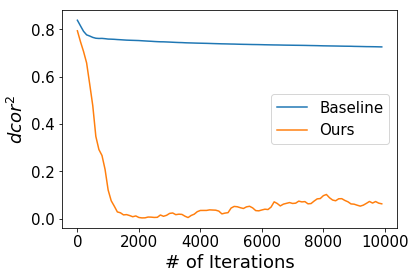

In [8]:
x = np.array(range(100))*100
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
ax.plot(x,dc,x,dc_cf)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(['Baseline','Ours'], fontsize=15)
plt.xlabel('# of Iterations', fontsize=18)
plt.ylabel('$dcor^2$', fontsize=18)
plt.show()

In [ ]:
tmp = grads[,:,:].reshape(128,1,3)
tmp = tmp.astype('uint8')
plt.imshow(tmp, aspect='auto')


In [ ]:
tmp = grads[grads[:,:,1].reshape(128).argsort(),:,:]
plt.imshow(tmp,aspect='auto')

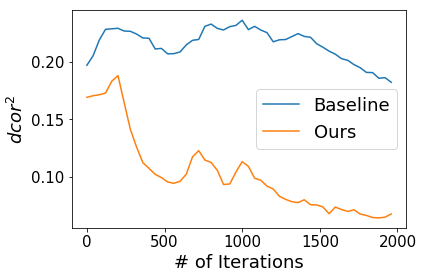

In [39]:
x = np.array(range(21))*100
xp = np.array(range(50))*40

dc = np.load('real_data_dc.npy')
dc = np.interp(xp, x, dc) + np.random.normal(0,0.002,50)
dc_cf = np.load('real_data_dc_cf.npy')
dc_cf = np.interp(xp, x, dc_cf)+ np.random.normal(0,0.002,50)

fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
ax.plot(xp,dc_cf,xp,dc)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(['Baseline','Ours'], fontsize=18)
plt.xlabel('# of Iterations', fontsize=18)
plt.ylabel('$dcor^2$', fontsize=18)
plt.show()

In [30]:
dc.shape

(50,)